In [1]:
# Choose : le type d'analyse que l'on veut faire : 'to_check' ou 'to_buy'

In [13]:
fichier = 'to_buy'

In [14]:
# Choisir le numéro de la collection à analyser dans fichier

In [15]:
num = 2

In [16]:
import requests 
from bs4 import BeautifulSoup
import pandas as pd
import json
import matplotlib.pyplot as plt


if fichier == 'to_check':
    CSV = pd.read_csv(r'C:\Users\marti\Desktop\THP\PF\CSV_STRAT\ALLTIME_TOP_N_TOCHECK.csv')
else: CSV = pd.read_csv(r'C:\Users\marti\Desktop\THP\PF\CSV_STRAT\NEW_TOBUY.csv')

del CSV['Unnamed: 0']
        
url = 'https://cnft.tools/' + CSV.name[num]

r = requests.get(url)
soup = BeautifulSoup(r.content, 'html.parser')

In [17]:
url

'https://cnft.tools/thejrney'

In [18]:
script = soup.find_all('script')[3].text.strip()

In [19]:
début = script.find('let nameList = \'[')
fin = script.find('\';\n    let mintCount =')

In [20]:
scriptj= script[début+16:fin]

In [21]:
data = json.loads(scriptj)

In [22]:
df = pd.DataFrame(data)

In [24]:
##Création du nouveau tableau
df2 = pd.DataFrame().assign(rarityRank=df['rarityRank'], assetID=df['assetID'], assetName=df['assetName'], price=df['price'], prices=df['prices'])

#Changement du type des colonnes
df2["rarityRank"] = df["rarityRank"].astype('int')
df2["assetID"] = df["assetID"].astype('int')

df2["price"] = df2.price.mask(df2.price == 'x')
df2["price"] = df2['price'].astype('Int64')

df2["prices"] = df2["prices"].astype('str')
df2["prices"] = df2['prices'].mask(df2['prices'] == '{}')


##changement du prices où on ne veut garder que le nom de la marketplace
i = 0 
while i < len(df2):
    if pd.isna(df2.prices[i]) : 
        df2.loc[i, 'prices'] = 'not in sale'
    else: df2.loc[i, 'prices'] = df2.prices[i][2:df2.prices[i].find("': {'id':")]
    i+= 1

In [25]:
onsale = df2[df2['price'].notnull()]

In [26]:
onsale

,rarityRank,assetID,assetName,price,prices
4,6531,215,TheJRney0215,450000000,jpgStore
6,2320,684,TheJRney0684,89000000,jpgStore
13,3392,162,TheJRney0162,200000000,jpgStore
22,2082,592,TheJRney0592,1800000000,jpgStore
25,2040,8,TheJRney0008,390000000,jpgStore
...,...,...,...,...,...
6479,6119,1130,TheJRney1130,120000000,jpgStore
6495,4302,2797,TheJRney2797,99000000,jpgStore
6506,1252,3826,TheJRney3826,200000000,jpgStore
6522,1128,5217,TheJRney5217,88000000,jpgStore


In [14]:
#reformatage rapide 
onsale.rename(columns = {'prices':'Marketplaces'}, inplace = True)
onsale = onsale[['rarityRank','assetID','assetName','Marketplaces','price',]]

C:\Users\marti\AppData\Local\Temp\ipykernel_10344\3362478385.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  onsale.rename(columns = {'prices':'Marketplaces'}, inplace = True)


In [15]:
#Rajouter un catégorie d'appartenance selon la rareté

onsale['classement'] = 1   

In [16]:
onsale = onsale.reset_index(drop=True)

i = 0
while i < len(onsale):
    if onsale.rarityRank[i] < 51 : 
        onsale.classement[i] = "[1-50]"
    elif onsale.rarityRank[i] < 101 : 
        onsale.classement[i] = "[51-100]"
    elif onsale.rarityRank[i] < 201 : 
        onsale.classement[i] = "[101-200]"
    elif onsale.rarityRank[i] < 501 : 
        onsale.classement[i] = "[201-500]"
    elif onsale.rarityRank[i] < 1201 : 
        onsale.classement[i] = "[501-1200]" 
    else : onsale.classement[i] = "[1201-MAX]"
    i+=1

C:\Users\marti\AppData\Local\Temp\ipykernel_10344\2464819010.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  else : onsale.classement[i] = "[1201-MAX]"


In [17]:
#Va savoir pourquoi, le price est multiplié par 1000000
onsale['price'] = onsale['price'] / 1000000

In [18]:
#Rajouter le price moyen de la catégorie 
#créer une colonne, qui dit warning X % de décalage avec la moyenne 

In [19]:
onsale['médiane_de_classe'] = 1
onsale['différence_relative_à_la_MC'] = 1
onsale['médiane_de_marketplace'] = 1
onsale['différence_relative_à_la_MMP'] = 1

In [20]:
#Création des df des moyennes
MC = pd.DataFrame(onsale.groupby(['classement'])['price'].median())
MMP = pd.DataFrame(onsale.groupby(['Marketplaces', 'classement'])['price'].median())

In [21]:
MC = MC.reset_index()
MMP = MMP.reset_index()

In [22]:
#Ajouter pour chaque pièce, le prix de la MMP et du classement. 

i = 0
while i < len(onsale): 
    y = 0
    while y < len(MC):
        if onsale.classement[i] == MC.classement[y]:
            onsale.médiane_de_classe[i] =  MC.price[y]
        y += 1
    i += 1

C:\Users\marti\AppData\Local\Temp\ipykernel_10344\1522866781.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  onsale.médiane_de_classe[i] =  MC.price[y]


In [23]:
i = 0
y = 0
while i < len(onsale): 
    y = 0
    while y < len(MMP):
        if onsale.Marketplaces[i] == MMP.Marketplaces[y]:
            onsale.médiane_de_marketplace[i] =  MMP.price[y]
        y += 1
    i += 1

C:\Users\marti\AppData\Local\Temp\ipykernel_10344\112717661.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  onsale.médiane_de_marketplace[i] =  MMP.price[y]


In [24]:
#Rajouter les distances relatives par rapport aux moyennes de classe et de MMP
onsale['différence_relative_à_la_MC'] =  ((onsale['price'] /onsale['médiane_de_classe'])-1)*100
onsale['différence_relative_à_la_MMP'] =  ((onsale['price'] /onsale['médiane_de_marketplace'])-1)*100

# SI ON EST DANS UN SCHEMA TO_BUY 

In [25]:
#IL faut acheter des pièces rares sur une base de prix x% moins cheros 

In [26]:
x = -65
y = -40

In [27]:
to_buy = onsale[(onsale.différence_relative_à_la_MC < x)]

In [28]:
to_buy['risque'] = 1

C:\Users\marti\AppData\Local\Temp\ipykernel_10344\2180513205.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  to_buy['risque'] = 1


In [29]:
to_buy = to_buy.reset_index(drop=True)

i = 0
while i < len(to_buy):
    if to_buy.rarityRank[i] < 100 : 
        to_buy.risque[i] = "A privilégier"
    elif to_buy.rarityRank[i] < 500 :
        to_buy.risque[i] = "Tanger danger"
    else :  to_buy.risque[i] = "Y aller si argent à perdre"
    i+=1

C:\Users\marti\AppData\Local\Temp\ipykernel_10344\4128867889.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  to_buy.risque[i] = "Tanger danger"


# SI ON EST DANS UN SHEMA TO_CHECK


In [30]:
to_check = onsale[(onsale.différence_relative_à_la_MC < y)]

In [31]:
to_check['risque'] = 1

C:\Users\marti\AppData\Local\Temp\ipykernel_10344\1849566061.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  to_check['risque'] = 1


In [32]:
to_check = to_buy.reset_index(drop=True)

i = 0
while i < len(to_buy):
    if to_buy.rarityRank[i] < 100 : 
        to_buy.risque[i] = "A privilégier"
    elif to_buy.rarityRank[i] < 500 :
        to_buy.risque[i] = "Tanger danger"
    else :  to_buy.risque[i] = "Y aller si argent à perdre"
    i+=1

C:\Users\marti\AppData\Local\Temp\ipykernel_10344\202113293.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  to_buy.risque[i] = "Tanger danger"
C:\Users\marti\AppData\Local\Temp\ipykernel_10344\202113293.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  to_buy.risque[i] = "A privilégier"
C:\Users\marti\AppData\Local\Temp\ipykernel_10344\202113293.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  else :  to_buy.risque[i] = "Y all

In [34]:
to_buy

,rarityRank,assetID,assetName,Marketplaces,price,classement,médiane_de_classe,différence_relative_à_la_MC,médiane_de_marketplace,différence_relative_à_la_MMP,risque
0,377,274,TheJRney0274,jpgStore,129.0,[201-500],500,-74.2,625,-79.36,Tanger danger
1,425,3425,TheJRney3425,jpgStore,170.0,[201-500],500,-66.0,625,-72.8,Tanger danger
2,108,5169,TheJRney5169,jpgStore,139.0,[101-200],500,-72.2,625,-77.76,Tanger danger
3,33,2591,TheJRney2591,jpgStore,333.0,[1-50],1249,-73.338671,625,-46.72,A privilégier
4,88,3453,TheJRney3453,jpgStore,198.0,[51-100],625,-68.32,625,-68.32,A privilégier
5,166,6380,TheJRney6380,jpgStore,150.0,[101-200],500,-70.0,625,-76.0,Tanger danger
6,116,4119,TheJRney4119,jpgStore,149.0,[101-200],500,-70.2,625,-76.16,Tanger danger
7,4767,5555,TheJRney5555,jpgStore,55.0,[1201-MAX],160,-65.625,625,-91.2,Y aller si argent à perdre
8,396,1460,TheJRney1460,jpgStore,150.0,[201-500],500,-70.0,625,-76.0,Tanger danger
9,1200,3489,TheJRney3489,jpgStore,89.0,[501-1200],270,-67.037037,625,-85.76,Y aller si argent à perdre


In [35]:
to_buy[(to_buy.risque == 'A privilégier')]

,rarityRank,assetID,assetName,Marketplaces,price,classement,médiane_de_classe,différence_relative_à_la_MC,médiane_de_marketplace,différence_relative_à_la_MMP,risque
3,33,2591,TheJRney2591,jpgStore,333.0,[1-50],1249,-73.338671,625,-46.72,A privilégier
4,88,3453,TheJRney3453,jpgStore,198.0,[51-100],625,-68.32,625,-68.32,A privilégier
11,24,4552,TheJRney4552,jpgStore,400.0,[1-50],1249,-67.97438,625,-36.0,A privilégier
12,30,3628,TheJRney3628,jpgStore,302.0,[1-50],1249,-75.820657,625,-51.68,A privilégier
13,43,5051,TheJRney5051,jpgStore,400.0,[1-50],1249,-67.97438,625,-36.0,A privilégier


In [53]:
urlp = 'https://api.opencnft.io/1/policy/'+ CSV.policies[num] + '/transactions'
rp = requests.get(urlp)

In [68]:
transactions = pd.json_normalize(rp.json()['items'])

In [64]:
transactions['price'] = transactions['price'] / 1000000

<AxesSubplot:title={'center':'rarity_rank'}, xlabel='marketplace'>

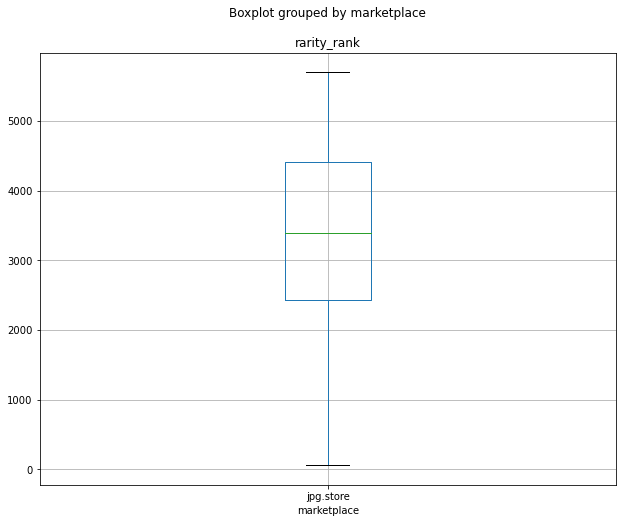

In [67]:
fig, ax = plt.subplots(figsize=(10,8))
plt.suptitle('')
transactions.boxplot(column=['rarity_rank'], by='marketplace', ax=ax)

<AxesSubplot:title={'center':'price'}, xlabel='Marketplaces'>

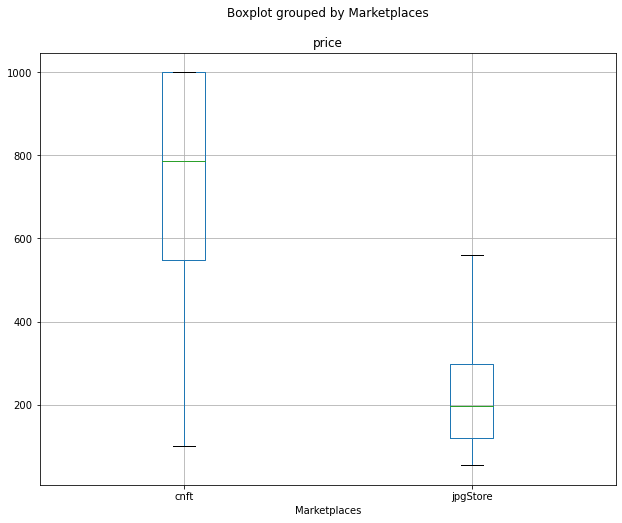

In [42]:
fig, ax = plt.subplots(figsize=(10,8))
plt.suptitle('')
onsale.boxplot(column=['rarity_rank'], by='Marketplaces', ax=ax, showfliers=False)